In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.13.0


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

In [5]:
with pm.Model() as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


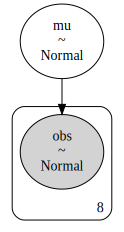

In [17]:
pm.model_to_graphviz(pooled)

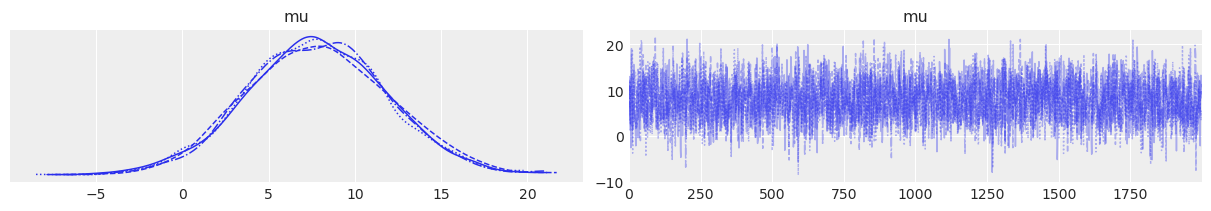

In [6]:
az.plot_trace(trace_p);

In [7]:
with pooled:
    pm.compute_log_likelihood(trace_p)
pooled_loo = az.loo(trace_p)

pooled_loo

Output()

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.59     1.10
p_loo        0.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [8]:
with pm.Model() as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

    trace_h = pm.sample(2000, target_accept=0.9)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


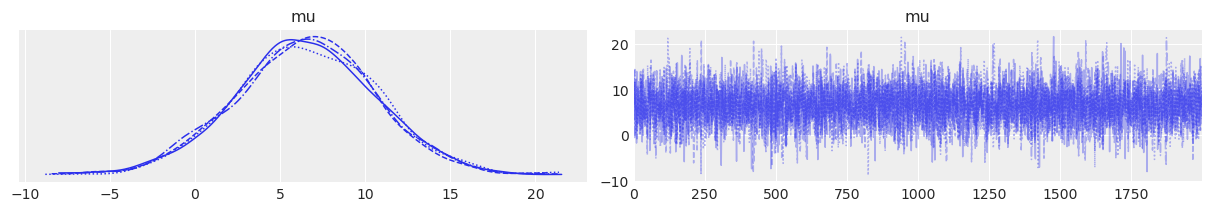

In [9]:
az.plot_trace(trace_h, var_names="mu");

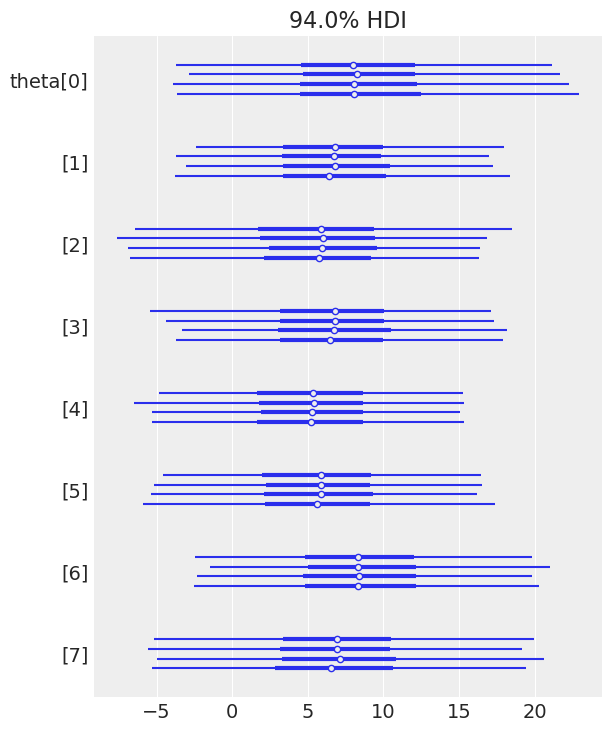

In [10]:
az.plot_forest(trace_h, var_names="theta");

In [11]:
with hierarchical:
    pm.compute_log_likelihood(trace_h)
hierarchical_loo = az.loo(trace_h)

hierarchical_loo

Computinng ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.81     1.08
p_loo        1.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3   37.5%
 (0.5, 0.7]   (ok)          5   62.5%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.591562,0.701350,0.000000,1.0,1.096051,0.000000,False,log
hierarchical,1,-30.811028,1.150242,0.219466,0.0,1.082425,0.249968,False,log


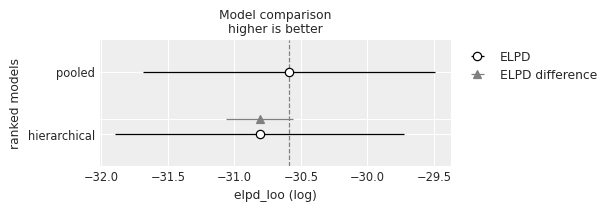

In [13]:
az.plot_compare(df_comp_loo, insample_dev=False);